#### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
games_data = pd.read_csv('/datasets/games.csv')

In [3]:
print(games_data.info())
games_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Шаг 2. 
### Предобработка данных.

#### Приводим названия столбцов и жанров к нижнему регистру.

In [4]:
games_data.columns = games_data.columns.str.lower()
games_data.columns
# Приведем названия столбцов к нижнему регистру. 

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
games_data['genre'] = games_data['genre'].str.lower()
# Так же приведем названия жанров к нижнему регистру.

#### Преабразуем данные к нужным типам

In [6]:
games_data['year_of_release'] = games_data['year_of_release'].astype('Int64')

In [7]:
games_data['user_score'] = pd.to_numeric(games_data['user_score'], errors='coerce')

Аббревиатура "tbd" рашивровывется как to be determined (будет определено позднее). Это означает, что у игры еще нет пользовательского рейтинга, потому что сликом мало людей ее оценило. Учитывая это, мы можем зменить значения "tbd" на "NaN", а числовые значения пивести к типу float.

#### Посчтаем сумарные продажи по всем регионам и запишем их в новый столбец

In [8]:
games_data['world_sales'] = (games_data['na_sales'] + 
                             games_data['eu_sales'] + 
                             games_data['jp_sales'] + 
                             games_data['other_sales']
                            )
games_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


#### Обработка пропусков

In [9]:
print(games_data['rating'].value_counts())

games_data['rating'] = games_data['rating'].replace('K-A', 'E')

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64


K-A - это устаревшее обозначение рейтинка Е, поэтому можем заменить значение "K-A" на значение "Е"

In [10]:
print(games_data['genre'].isna().sum())
print(games_data['year_of_release'].isna().sum())

games_data.dropna(subset = ['name', 'year_of_release'], inplace = True) 

2
269


В столбце с названием игры и жанром имеем 2 строки с пропущенными значениями. Наиболее вероятно, что это одна игра, которая вышла в Японии и других регионах. Избавимся от нее, так как мы не знаем, что это была за игра.

В столбце с годом выпуска имеем 269 пропущенных значений. Они состовяляют 1.5% от всего датасета, поэтому можем от них избавиться. Это не должно повлиять на итоговые результаты.

## Шаг 3. 
### Исследовательский анализ данных 

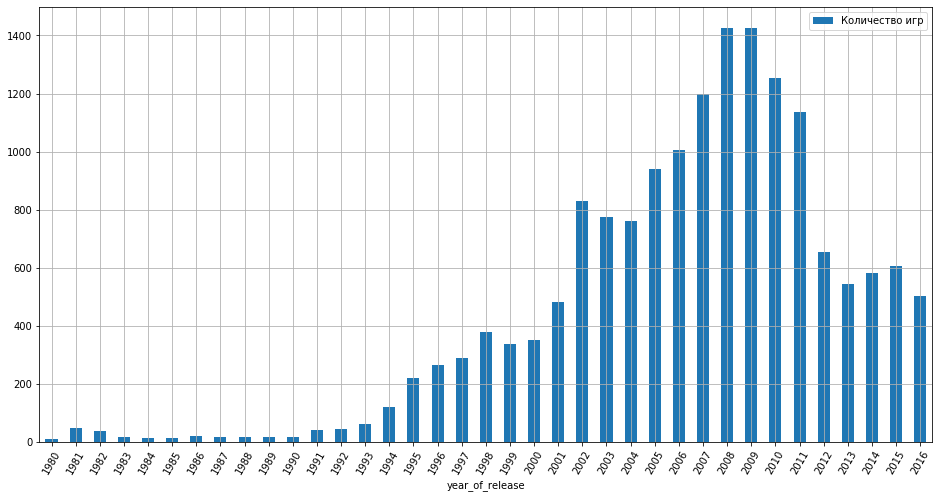

In [11]:
games_by_year = games_data.groupby('year_of_release')['name'].count()
games_by_year.plot(kind='bar',
                   label='Количество игр',
                  grid=True,
                  legend=True,
                  figsize=(16,8),
                  rot=60);

plt.show()


На графике мы видим несколько отрезков:

1) С 1980 по 1993 год. Количество игр не более 50 шт в год.

2) Первая волна роста с 1994 по 2001 год. Рост связан с появление на рынке PlayStation 1. Количество игр постепенно увеличивается.

3) Резкий скачек в 2002 году. Скорее всего он связан с появление первой консоли Xbox в ноябре 2001 года.

4) С 2001 года количество игр увеличивается с каждым годом и достигает своего пика в 2008-2009 годах. Рост, наиболее вероятно связан с увеличением мощности PC и появлением нового поколения консолей (PS3 и Xbox360) 

5) После 2009 года количество игр начинает уменьшаться и в 2012 году становится почти в два раза меньше по сравнению с 2011 годом. Возможно это связано с увеличиным сроком производства игр. Так же. вероятно, повлиял анонс следующего поколеня консолей (PS4 и Xbox One), которые вышли в 2013 году.

6) С 2012 по 2016 годы количество игр держтся на уровне 550-650 игр в год.

##### Вывод: данные за весь период не очень важны в прогнозировании, так как было несолько кардинально разных периодов, связаных с развитем технологий того времени.

In [12]:
platforms_sales = (games_data.pivot_table(index='platform', values='world_sales', aggfunc='sum')
                       .sort_values(by='world_sales', ascending=False)
                       .reset_index()
                       )
top10_platforms = platforms_sales['platform'].head(10)

sales_per_year = (games_data.query('platform in @top10_platforms')
                            .pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
                 )

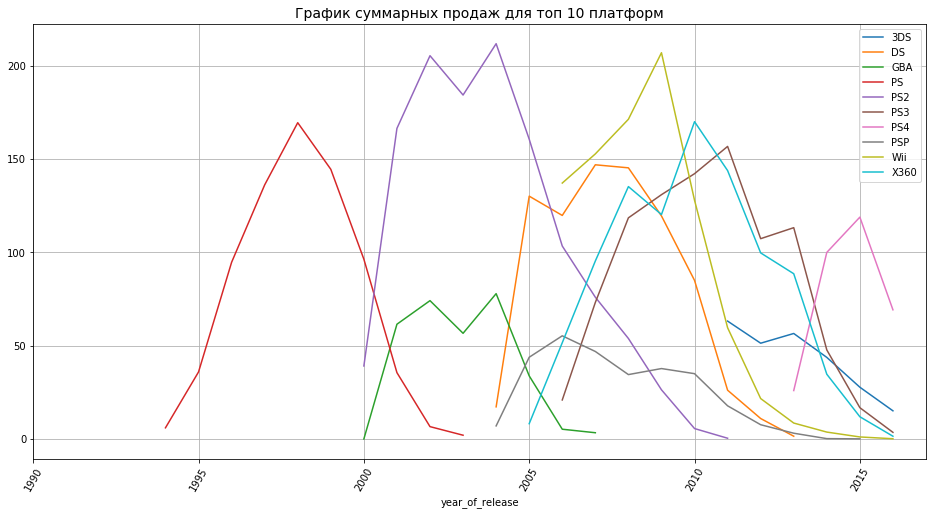

In [13]:
(sales_per_year.plot(kind='line',
                  grid=True,
                  legend=True,
                  figsize=(16,8),
                  rot=60,
                  xlim=(1990, 2017))
                

);
plt.title('График суммарных продаж для топ 10 платформ', fontsize=14)
plt.legend(loc='best')
plt.show();

<p style="color:green">Отличная визуализация получилась</p>

На графике видно, что срок жизни платформы состовляет около 8 лет. В первую половину этого срока объем продаж растет, к середине он достигает пика, а после этого падает. Так же на графике видна сменяемость поколений консолей. Рост новой консоли совпадает со спадом продаж на старой.

Так же можно заметить, что продажи на  мобильных консолях (PSP, DS, 3DS, GBA) в несколько раз меньше продаж на стационарных консолях (Play Station, Xbox)

##### Выберем актуальный период, по которому будем строить прогноз.

In [14]:
(games_data.pivot_table(index='platform', values='year_of_release', aggfunc='min')
                       .sort_values(by='year_of_release', ascending=False)
                       .reset_index()
                       .head()
)

,platform,year_of_release
0,XOne,2013
1,PS4,2013
2,WiiU,2012
3,3DS,2011
4,PSV,2011


Выберем самые современные платформы. Так же добавим к ним "PC" как неустаревающую платформу. 
Установим границы актуального периода: с 2012 по 2015 год. В этот период не было сильных скачков по количеству игр. Так же в этот преиод присутсвуют все актуальные платформы. 2016 год не включаем в этот период, из=за неполных данных.
    
    
    
Построим график общемировых продаж, для современных платформ.

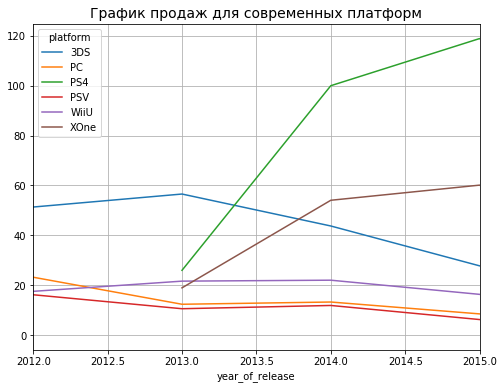

In [15]:
(games_data.query('platform ==["XOne", "PC", "PS4", "WiiU", "3DS", "PSV"]')
           .pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
           .plot(kind='line',
                  grid=True,
                  legend=True,
                  figsize=(8,6),
                  xlim=(2012, 2015)
                  )
                 );
plt.title('График продаж для современных платформ', fontsize=14);

Из графика можно выделить следующие виды платформ:
- #### Потенциально прибыльные.
Рост платформ PS4 и Xbox One. Учитывая средний цикл обновления платформы, эти консоли будут показывать рост еще 2-3 года
- #### Потенциально убыточные. 
Падение продаж мобильных платформ (PS Vita, 3DS). Ниболее веротно, что это связано с ростом популярности игр на смартфонах.
- #### Стабильные.
На PC мы не видим ни роста, ни падения. Платформа имеет стабильные показатели на протяжении долгого времени. Невысокие показатели продаж, вероятно, связаны с тем, что цена на игры на PC в несколько раз ниже, чем на консолях. Так же нельзя исключать фактор пиратства. 

In [16]:
#создадим таблицу с актуальным периодом.
actual_games_data = games_data.query('(year_of_release >= 2012) and (year_of_release <= 2015)').reset_index(drop=True)

<p style="color:green">Всё верно</p>

##### Построим график "ящик с усами" по глобальным продажам с разбивкой для каждой платформы. Так же посчитаем сумму, медианные, средние значения продаж.

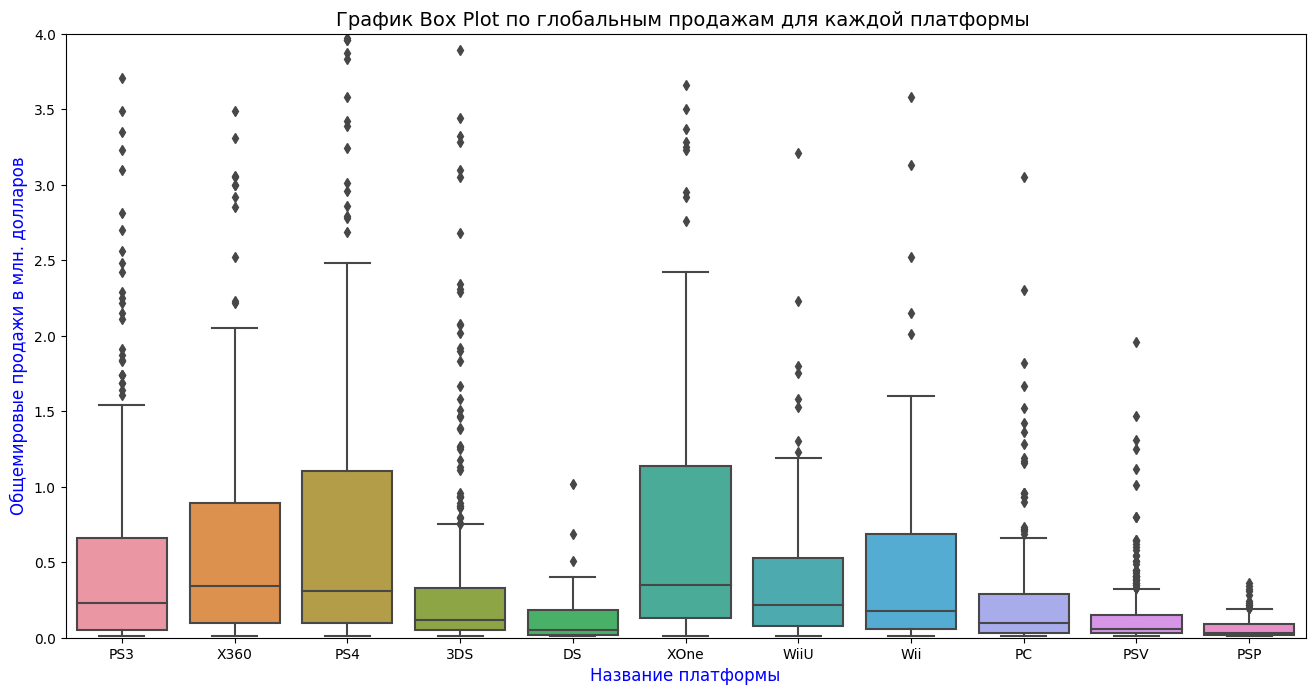

In [17]:
plt.subplots(figsize=(16,8), dpi=100)
sns.boxplot(y='world_sales',
            x='platform',
            data=actual_games_data);

plt.title('График Box Plot по глобальным продажам для каждой платформы ', fontsize=14)
plt.ylim(0, 4)
plt.xlabel('Название платформы', fontsize=12, color='blue')
plt.ylabel('Общемировые продажи в млн. долларов', fontsize=12, color='blue')
plt.show()

In [18]:
world_sales_mean = (actual_games_data.pivot_table(index='platform', values='world_sales', aggfunc=['median', 'mean', 'sum'])
                                    .reset_index()
                  )

world_sales_mean.set_axis(['platform', 'median', 'mean', 'sum'], axis='columns', inplace=True)
world_sales_mean.sort_values(by='mean', ascending=False)

,platform,median,mean,sum
4,PS4,0.310,1.074079,244.89
9,X360,0.340,0.842366,235.02
10,XOne,0.350,0.832312,133.17
7,Wii,0.180,0.663962,35.19
3,PS3,0.230,0.626791,285.19
8,WiiU,0.220,0.583383,77.59
0,3DS,0.115,0.512771,179.47
1,DS,0.050,0.404839,12.55
2,PC,0.100,0.292857,57.40
6,PSV,0.060,0.137822,44.93


Из графика и сводной таблицы видно что лидеры в продажах одни и теже. У стационарных консолей средние и медианные показатели выше, чем у портативных консолей и PC. Такая разница получается из того, что на стационарных консолях игры значительно дороже, чем на других платформах.

Так же имеется разница между средним и медианным значением. Из таблицы видно, что среднее значение больше медианного в 3-5 раз.
Из этого следует, что есть небольшое количество игр, которые имеют большие продажы, и большое количество игр с маленькими продажами.

##### Выберем консоль с наибольшем количеством игр.  И посмотрим, как влияют на продажы отзывы пользователей и критиков.

In [19]:
#Создадим функцию для выведения диаграммы рассеяния
def scatterplot(column_x, column_y, data, title, xlabel, ylabel):
    
    """Создадим функцию для выведения диаграммы рассеяния. 
    На вход функция получает значения х, значения y, датасет, а также названия графика, ординаты и абсциссы."""   
    
    plt.subplots(figsize=(10,5), dpi=80)
    plt.scatter(x=column_x,
                y=column_y,
                data=data);
    plt.title(title, fontsize=14)
    plt.ylim(0, 15)
    plt.xlabel(xlabel, fontsize=12, color='blue')
    plt.ylabel(ylabel, fontsize=12, color='blue')
    plt.show()


In [20]:
(actual_games_data.pivot_table(index='platform', values='name', aggfunc='count')
                  .reset_index()
                  .sort_values(by='name', ascending=False)
                  .head()
)

,platform,name
3,PS3,455
0,3DS,350
6,PSV,326
9,X360,279
4,PS4,228


Платформа с наибольшим количеством игр - PS3. Рассомтрим ее, а также PS4, как наиболее перспективную.

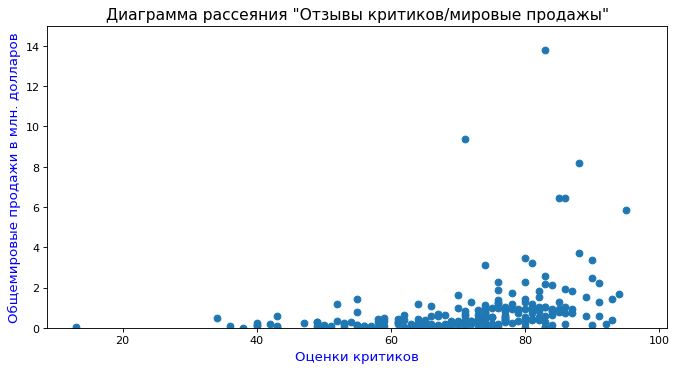

In [21]:
PS3_games = actual_games_data.query('(platform == "PS3") & (critic_score.isnull() == False)')
scatterplot('critic_score',
            'world_sales',
            PS3_games,
            'Диаграмма рассеяния "Отзывы критиков/мировые продажы"',
            'Оценки критиков',
            'Общемировые продажи в млн. долларов')


На диаграмме мы видим следующее:
- Большая часть игр имеет оценки в промежутке от 60 до 80.
- Очень небольшое количество игр заработали больше 4 млн.
- Игры заработавшие больше 1 млн. в большинстве имеют рейтинг 70 и выше.

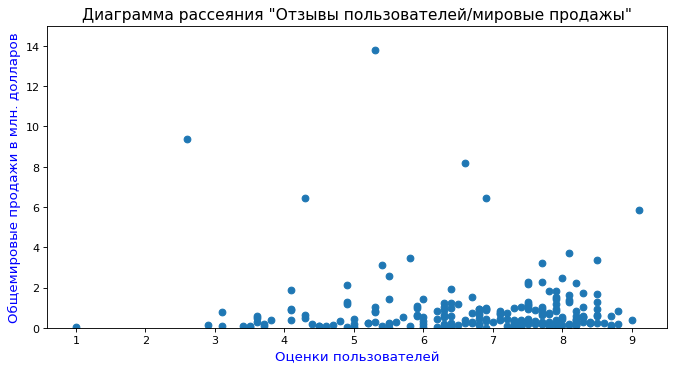

In [22]:
scatterplot('user_score',
            'world_sales',
            PS3_games,
            'Диаграмма рассеяния "Отзывы пользователей/мировые продажы"',
            'Оценки пользователей',
            'Общемировые продажи в млн. долларов')

Оценки пользоветеле в целом не сильно разнятся с оценками критиков. Основная масса игр меет оценки от 6 до 8. 

Но в тоже время продажы игр меньше зависимы от оценок пользователей. Такой вывод можно сделать, так как игры заработавшие 1 млн и больше имеют оценки от 4 до 9. И это распределение достаточно ровное, в отличие от такого же распределения в оценках критиков.


In [23]:
# Посчитаем коэфицент корреляции Пирсона
print('Кореляция "Оценка критиков к продажам" = {:.3f}'
      . format(PS3_games['critic_score'].corr(PS3_games['world_sales'])))

print('Кореляция "Оценка пользователей к продажам"= {:.3f}'
      . format(PS3_games['user_score'].corr(PS3_games['world_sales'])))

Кореляция "Оценка критиков к продажам" = 0.331
Кореляция "Оценка пользователей к продажам"= 0.003


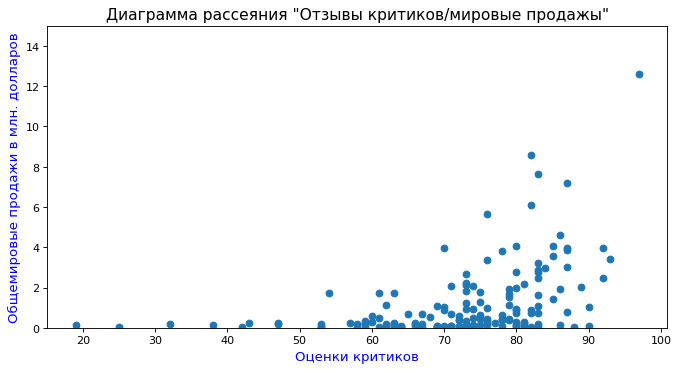

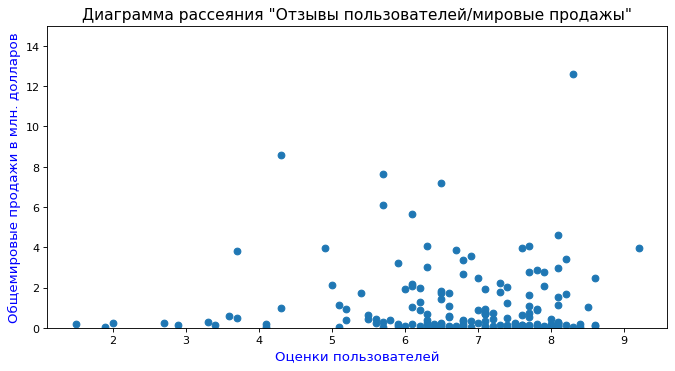

Кореляция "Оценка критиков к продажам" = 0.432
Кореляция "Оценка пользователей к продажам"= 0.018


In [24]:
# Проделаем теже манипуляции с PS4.
PS4_games = actual_games_data.query('(platform == "PS4") & (critic_score.isnull() == False)')
scatterplot('critic_score',
            'world_sales',
            PS4_games,
            'Диаграмма рассеяния "Отзывы критиков/мировые продажы"',
            'Оценки критиков',
            'Общемировые продажи в млн. долларов')

scatterplot('user_score',
            'world_sales',
            PS4_games,
            'Диаграмма рассеяния "Отзывы пользователей/мировые продажы"',
            'Оценки пользователей',
            'Общемировые продажи в млн. долларов')

print('Кореляция "Оценка критиков к продажам" = {:.3f}'
      . format(PS4_games['critic_score'].corr(PS4_games['world_sales'])))

print('Кореляция "Оценка пользователей к продажам"= {:.3f}'
      . format(PS4_games['user_score'].corr(PS4_games['world_sales'])))

Результаты на двух платформах похожи.

##### Из графиков и коэфицентов корреляции Пирсона можно сделать следующие выводы:
- Оценки критиков имеют влияние на продажи игр, но это влияние на одних платформах выражено средне (коэф. Пирсона = 0.4), на других слабо (коэф. Пирсона <= 0.3). 
    Существуют примеры игр с высокой оценкой, но низкими продажами. Скорее всего это игры получившие популярность во всем мире, а продававшиеся в одном регионе. Так же есть и обратные примеры: невысокий рейтинг, но большие продажы. Возможно, что это игры, являющиеся продолжением какх-то серий (FIFA, Call of Duty). Эти игры не получают высоких оценок, но продаются большими тиражами.

- Оценки игроков не имеют никакого влияния на продажы игр. (коэф. Присона < 0.1). Возможно, что это связано с тем, что основные продажи формируются в первые месяцы продаж, тогда как оценки пользоветелей публикуются значительно позже, в отличие от оценок критиков, которые доступны одновременно с выходом игр.

##### Сделаем разбивку по жанрам и определим самые популярные и непопулярные жанры.

In [25]:
(actual_games_data.pivot_table(index='genre', values='world_sales', aggfunc='sum')
                  .sort_values(by='world_sales', ascending=False)
                  .reset_index()
)

,genre,world_sales
0,action,411.01
1,shooter,266.51
2,role-playing,174.62
3,sports,157.58
4,misc,82.44
5,platform,57.77
6,racing,50.71
7,fighting,40.02
8,simulation,33.23
9,adventure,25.61


Как мы видим, жанры с лидерами продаж являются жанры "Экшн" и "Шутер". Это не удевительно, так как в разработку и рекламу этих игр вкладываются больше всего. Это самые популярные жанры.

На 3 месте идут ролевые игры (RPG) Этот жанр так же популярен и среди его представителей есть большое количество дорогоих и качественных игр.

Замыкает четверку лидеров с отрывом от 5 места почти в 2 раза жанр "Спорт". Игр этого жанра не так много, как игр из предыдущей тройка, но большинство спортивных игр это серии, которые иду годами (FIFA, PES, NHL, NBA и тд.) и каждый год игрока покупают игры тех серия, которые им полюбились. Поэтому у данного жанра, как мне кажется, достаточно стабильные показатели.

Жанрами с наименьшим количесвом продаж являются жанры "Пазлы" и "стратегии". Небольшой объем продаж возможно связан с тем, что данные игры не очень дорогие и распросраняются преимущественно на мобильных платформах. Жанр стратегий ранее был популярен, но сейчас в том жанре не так много игр.

### Вывод. 

Проведя анализ имеющихся данных мы выяснили следующее:

1) Актуальный перод для построения прогноза на следующий год с 2012 по 2015 год. Мы выбрали этот отрезок потому что
    - за этот период не было больших различий в количестве выпущенных за год игр.
    - в этом пероде присутствуют все актуальные платформы.
    - данные за 2016 год не полные и могут исказить картину.
2) Самыми перспективными платформами можем считать PS4 b Xbox One, так как это относително новые платформы, которые показываеют рост продаж и у которых впереди еще 2-3 года активного роста. Так же не будем исключать PC, показывающего стабильные результаты в течение длительного времени.

3) Выяснили, что оценки пользователей не влияют на продажи игр, а оценки критиков имеют достаточное влияние, что бы учитывать их в дальнейшем.

4) Нашли жанры, на которые стоит делать стваку: Action/Shooter, RPG, Sport.

## Шаг 4.
### Портрет пользователя.

In [26]:
def ratio_sales(group_column, region):
    ratio_sales = actual_games_data.groupby(group_column)[region].sum().sort_values(ascending=False).head()
    data_ratio = pd.DataFrame(ratio_sales/ratio_sales.sum()).style.format('{:.1%}')
    return data_ratio

In [27]:
ratio_sales('platform', 'na_sales')

,na_sales
platform,
X360,30.3%
PS3,22.4%
PS4,19.0%
XOne,17.2%
3DS,11.1%


In [28]:
ratio_sales('platform', 'eu_sales')



,eu_sales
platform,
PS4,29.5%
PS3,28.5%
X360,19.9%
XOne,11.3%
3DS,10.9%


In [29]:
ratio_sales('platform', 'jp_sales')

,jp_sales
platform,
3DS,51.8%
PS3,22.1%
PSV,11.3%
WiiU,8.0%
PSP,6.8%


Выделив 5 самых популярных платформ в разных регионах мы видим что популярные платформы в разных регионах отличаются.
- В Северной Америке преимущество у американских платформ Xbox 360 и Xbox One. У них почти 50% рынка. Это можно объяснить хорошими промо компаниямии узнаваемостью бренда Microsoft.
- В Японии лидерство делят 2 местные компании Nintendo с консолью 3DS (~ 52 % рынка) и Sony с консолями PS3, PS Vita и PSP (~ 42% рынка). Другие компании практически не представлены. Это объясняется закрытостью японского рынка.
- В Европе рынок делять между собой Sony с Play Station 3 и 4 (58%) и Microsoft с Xbox 360 и One (31%). Здесь видим почти двухкратное преимущество Sony. 

In [30]:
ratio_sales('genre', 'na_sales')

,na_sales
genre,
action,36.1%
shooter,27.5%
sports,15.9%
role-playing,12.5%
misc,8.0%


In [31]:
ratio_sales('genre', 'eu_sales')

,eu_sales
genre,
action,39.8%
shooter,26.1%
sports,15.3%
role-playing,11.9%
misc,6.9%


In [32]:
ratio_sales('genre', 'jp_sales')

,jp_sales
genre,
role-playing,43.5%
action,33.8%
misc,8.7%
simulation,7.5%
fighting,6.4%


Как мы видим, разница в популярных жанрах в Европе и Америке практически отсутствует. Пользовтели из этих регионов предпочитают одни и теже жанры. 

В Японии совсем другое распределение. Наибольшей популярностью пользуется жанр ролевых игр. Возможно, это из-за того, что игры в том жанре выпускают Японские компании и преимущественно для внутренего рынка. К тому же данный жанр больше подходит под самую популярую консоль - 3DS.

In [33]:
ratio_sales('rating', 'na_sales')

,na_sales
rating,
M,47.8%
E,23.6%
E10+,15.9%
T,12.6%


In [34]:
ratio_sales('rating', 'eu_sales')

,eu_sales
rating,
M,47.7%
E,26.8%
E10+,13.9%
T,11.6%


In [35]:
ratio_sales('rating', 'jp_sales')

,jp_sales
rating,
E,34.6%
T,30.2%
M,25.4%
E10+,9.8%


Снова видим, что в европейском и американском регионах распределение похоже, а в Японии отличается.
В Америки и Европе почти половина игр имеет рейтинг M (от 17 лет). В Японии большинство иг имеют рейтиги Е (от 6 лет) и Т (от 13 лет). Такие различия могут происходить по нескольким причинам:

1) В Европе и Америке большое количество взрослых (старше 18 лет) игроков, тогда как в Японии в игроками преимущественно являются дети, а не взрослые.

2) Распределение по возрасту примерно одинаково для всех регионов, но в Европе и Америке к рейтингу игры придают меньше значения, чем в Японии. 

3) Популярность жанра имеет влияние на рейтинг игр. Самые популярные жанры в Европе и Америке - экшены имеют высокий возрастной рейтинг, тогда как ролевые игры могут иметь рейтинг ниже.

### Вывод.

Были выявлены портреты пользователей для каждого региона:

- В Америке пользователи преимущественно играют в экшены и спортивные симуляторы. Наибольшей популярностью пользуются консоли Microsoft (Xbox 360 и Xbox One)
- В Европе пользователи также преимущественно играют в экшены и спортивные симуляторы. Наибольшей популярностью пользуются консоли Sony (PS3 и PS4)
- В Японии пользователи преимущественно играют ролевые игры. Наибольшей популярностью пользуется консоль Nintendo 3DS

## Шаг 5.
### Проверка гипотез

##### Нулевая гипотиза (н0) №1
Средние пользовательские рейтинги платформ Xbox One равны средним пользовательским рейтингам PC

##### Альтернативная гипотиза (н1) №1 
Средние пользовательские рейтинги платформ Xbox One не равны средним пользовательским рейтингам PC


In [36]:
alpha = 0.05

Xbox_user_score = actual_games_data.query('(platform == "XOne") & (user_score.isnull() == False)')
PC_user_score = actual_games_data.query('platform == "PC" & (user_score.isnull() == False)')


results = st.ttest_ind(Xbox_user_score['user_score'],
                       PC_user_score['user_score'],
                       equal_var = False)
print('p-значение:', results.pvalue)



if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9441751855931831
Не получилось отвергнуть нулевую гипотезу


Так как p-значение больше значения alpha, мы не отвергаем нулевую гипотизу (н0) №1

##### Нулевая гипотиза (н0) №2
Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports

##### Альтернативная гипотиза (н1) №2
Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports


In [37]:
alpha = 0.05

action_user_score = actual_games_data.query('(genre == "action") & (user_score.isnull() == False)')
sports_user_score = actual_games_data.query('genre == "sports" & (user_score.isnull() == False)')


results = st.ttest_ind(action_user_score['user_score'],
                       sports_user_score['user_score'],
                       equal_var = False)
print('p-значение:', results.pvalue)



if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7671307856639633e-18
Отвергаем нулевую гипотезу


Так как p-значение намного меньше значения alpha, мы отвергаем нулевую гипотезу (н0) №2

### Вывод 

1) Проведя ttest для двух генеральных совокупностей "Оценки пользователей на платформе Xbox One" и "Оценки пользователей на платформе PC", получили р-значение мбольше порогового значения alpha. Исходя из этого мы не отвергаем нулевую гипотезу №1 и можем утверждать, что средний пользовательский рейтинг платформ Xbox One и PC одинаковый

2) Проведя ttest для двух генеральных совокупностей "Оценки пользователей для жанра Action" и "Оценки пользователей для жанра Sports", получили р-значение меньше порогового значения alpha. На этом основании можем отвергнуть нулевую гипотезу №2 и принять альтернативную гипотезу №2, что средние оценки пользоветелей для двух жанров разные.
    Можно предположить, что рейтинги у игр жанра Action выше, чем у жанра Sports, так как Action-игры имеют большие бюджеты и в целом выглядят более качественно. 

## Итоговый вывод.

1) Актуальным периодом для прогноза можно считать отрезок за последние 4-5 лет. За этот переиод количество выпущенных игр было стабильным (без резких скачков и провалов). Так же в этом периоде присутствуют все современные платформы.

2) В планировании компании на 2017 год следует уделить особое внимание растущим платформам (PS4, Xbox One). Так же стоит учесть PC, как самую стабильную платформу. В тоже время мабильные платформы (3DS, PS Vita) имеют тенденцию к снижению продаж и им не стоит уделять особого внимания.

3) Среди жанров, на которые стоит обратить внимание: самые популярные Action/Shooter и RPG, А так же имеющие стабильные продажи Sport.

4) Нужно принимать во внимание оценки критиков, так как их влияние, хоть и не очень сильное, но имеет место быть. Оценки пользоветелей, в целом, можно не учитывать. Но стоит обратить, если оценки становятся ниже 2.

